# Find points to scan an Az/El rotator for antenna and receiver testing

For this situation, we want to measure the received spectrum in various frequency bands over the entire hemisphere of antenna pointing directions.

* Find a list of equally-spaced points that cover the hemisphere.
* Order the points to minimize the time required to complete a scan.



## notes

Determining the order to visit a collection of points is the "traveling salesman problem" and is typically not practical to solve exactly.


https://estebanhufstedler.com/2020/01/02/traveling-salesman-problems-and-variants/



In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pymesh

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''
    # not originally my code, but forgot where it came from

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [4]:
center = np.array([0, 0, 0])
order = 2

m = pymesh.generate_icosphere(1.0, center, order)

vertices, _ = pymesh.mesh_to_graph(m)

In [5]:
# upper hemisphere only
idx = vertices[:, 2] >= 0
hemi = vertices[idx, :]
print(hemi.shape)


(89, 3)


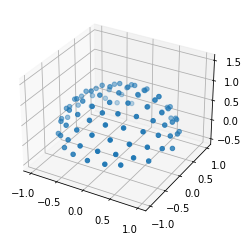

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = zip(*hemi)
ax.scatter(x, y, z)

set_axes_equal(ax)

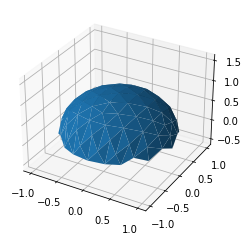

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = zip(*hemi)
ax.plot_trisurf(x, y, z)
set_axes_equal(ax)

In [8]:
from numpy.linalg import norm

def angle(a, b):
    return np.arccos(a.dot(b) / (norm(a) * norm(b)))


def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho


def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y


def sph2cart(az, el, r):
    rcos_theta = r * np.cos(el)
    x = rcos_theta * np.cos(az)
    y = rcos_theta * np.sin(az)
    z = r * np.sin(el)
    return x, y, z


def cart2pol(x, y=None, z=None):
    if y is None and z is None:
        z = x[:, 2]
        y = x[:, 1]
        x = x[:, 0]
        #x, y, z = z, x, y
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy) % (2*np.pi)  # 0...2pi range
    az = np.arctan2(y, x) % (2*np.pi)
    return np.stack((az, el, r), axis=1)

In [9]:
angle(hemi[0, :], hemi[1, :]) * 180 / np.pi

63.43494882292201

In [10]:
# sort by angular distance to 0,0

azelr = cart2pol(hemi)

az = azelr[:, 0]
el = azelr[:, 1]

lengths = np.abs(az) + np.abs(el)
idx = lengths.argsort()

hemi = hemi[idx, :]

In [11]:
import random
from copy import copy

def pathlength_azel(points):
    a = cart2pol(points[:-1, :])
    b = cart2pol(points[1:, :])
    azdiff = (a[:, 0] - b[:, 0])
    eldiff = (a[:, 1] - b[:, 1])
    
    s = (58/360)*np.abs(azdiff).sum() + (67/180)*np.abs(eldiff).sum()
    s *= 180 / np.pi  #convert to length in seconds of travel time
    return s, azdiff, eldiff


def pathlength_arc(points):
    # assume all points are on a sphere
    a = points[:-1, :]
    b = points[1:, :]
    d = np.sum(a * b, axis=1)
    absangles = np.abs(np.arccos(d))
    s = absangles.sum()
    return s, absangles

In [12]:
def findpath(points, mix=0):
    N = points.shape[0]
    tour = list(range(N))
    #tour = random.sample(range(N), N)
    distance, azdiff, eldiff = pathlength_azel(points[tour, :])
    
    print('{:.2f} {}'.format(distance, ''))
    for temperature in np.logspace(1, -1, num=100000):
        # swap a pair
        #i,j = sorted(random.sample(range(1, N), 2))
        #find long distances
        lengths = (58/360)*np.abs(azdiff) + (67/180)*np.abs(eldiff)
        #randomly choose a pair weighted towards the longest movements
        i, j = random.choices(range(1, N), weights=lengths, k=2)
        
        newTour = copy(tour)
        newTour[i], newTour[j] = newTour[j], newTour[i]
        newDistance, azdiff, eldiff = pathlength_azel(points[newTour, :])
        
        if np.exp((distance - newDistance) / temperature) > (mix * random.random() + 1 - mix):
            tour = newTour
            distance = newDistance
            #print('{:.2f} {:.2f}'.format(temperature, newDistance))
    print('{:.2f} {}'.format(distance, ''))
    return points[tour, :]

In [13]:
points = findpath(hemi, mix=0.0)

1581.91 
592.92 


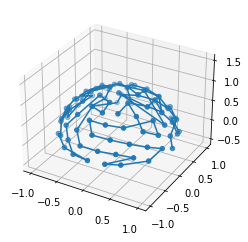

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = zip(*points)
ax.plot(x, y, z)
ax.scatter(x, y, z)
set_axes_equal(ax)

In [15]:
# heuristic
# find next closest point not yet visited

def short_path(hemi):
    N = len(hemi)
    tour = []
    remaining = list(range(N))

    #always start at (0az, 0el)
    tour.append(remaining.pop(0))
    for i in range(1, N-1):
        # az el distances from current point to remaining points
        azelr = cart2pol(hemi)
        here = azelr[tour[-1], :]
        others = azelr - here
        a = np.abs(others)

        lengths = (58/360)*a[:, 0] + (67/180)*a[:, 1]
        #lengths = np.max(np.stack(((58/360)*a[:, 0], (67/180)*a[:, 1]), axis=1), axis=1)
        #print(lengths)

        idx = lengths.argsort()
        for i in idx:
            if i not in tour:
                break

        tour.append(i)

    hpoints = hemi[tour, :]

    length, azdiff, eldiff = pathlength_azel(hpoints)
    print(length)
    return hpoints

In [16]:
hpoints = short_path(hemi)

487.14245743321936


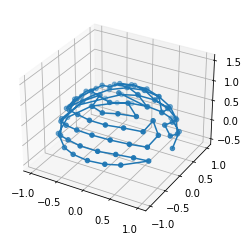

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = zip(*hpoints)
ax.plot(x, y, z)
ax.scatter(x, y, z)
set_axes_equal(ax)

In [18]:
cart2pol(hpoints)[:, 0:2]*180/np.pi

array([[  0.        ,   0.        ],
       [ 31.71747441,   0.        ],
       [ 58.28252559,   0.        ],
       [ 72.82796215,   0.        ],
       [ 90.        ,   0.        ],
       [107.17203785,   0.        ],
       [121.71747441,   0.        ],
       [148.28252559,   0.        ],
       [180.        ,   0.        ],
       [211.71747441,   0.        ],
       [238.28252559,   0.        ],
       [252.82796215,   0.        ],
       [270.        ,   0.        ],
       [287.17203785,   0.        ],
       [301.71747441,   0.        ],
       [328.28252559,   0.        ],
       [313.57234952,   8.48907956],
       [297.13337804,  13.81900921],
       [279.6937239 ,  15.24016228],
       [260.3062761 ,  15.24016228],
       [242.86662196,  13.81900921],
       [226.42765048,   8.48907956],
       [195.45043709,   9.34970354],
       [164.54956291,   9.34970354],
       [133.57234952,   8.48907956],
       [117.13337804,  13.81900921],
       [ 99.6937239 ,  15.24016228],
 

In [19]:
arclen, lengths = pathlength_arc(hpoints)
print(lengths * 180/np.pi)

[31.71747441 26.56505118 14.54543656 17.17203785 17.17203785 14.54543656
 26.56505118 31.71747441 31.71747441 26.56505118 14.54543656 17.17203785
 17.17203785 14.54543656 26.56505118 16.93697311 16.97815913 16.93697311
 18.69940709 16.93697311 16.97815913 30.60518978 30.48032457 30.60518978
 16.97815913 16.93697311 18.69940709 16.93697311 16.97815913 30.60518978
 16.93697311 14.54543656 14.54543656 17.17203785 18.         18.
 18.         18.         18.         18.         30.20990531 14.54543656
 14.54543656 27.63801841 16.93697311 16.93697311 16.97815913 16.93697311
 18.69940709 16.93697311 16.97815913 16.93697311 18.69940709 16.93697311
 16.97815913 17.17203785 18.         18.         18.         18.
 18.         18.         36.         18.         16.93697311 14.54543656
 14.54543656 17.17203785 18.         16.93697311 35.6363802  18.
 18.         16.93697311 14.54543656 14.54543656 17.17203785 18.
 16.93697311 30.60518978 16.93697311 16.97815913 16.93697311 33.79304894
 16.936973

In [20]:
hhpoints = findpath(hpoints, mix=0.1)

487.14 
473.66 


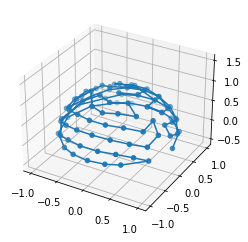

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = zip(*hhpoints)
ax.plot(x, y, z)
ax.scatter(x, y, z)
set_axes_equal(ax)

# Fibonacci sphere

In [22]:

def fibonacci_sphere(N):
    from numpy import arange, pi, sin, cos, arccos
    N *= 2  # we are only taking the upper hemisphere
    i = arange(0, N, dtype=float) + 0.5
    phi = arccos(1 - 2*i/N)
    goldenRatio = (1 + 5**0.5)/2
    theta = 2 * pi * i / goldenRatio
    x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi)
    idx = (z >= 0)
    x = x[idx]
    y = y[idx]
    z = z[idx]

    points = np.stack([x, y, z], axis=1)
    start = np.array([[1, 0, 0]])
    diff = np.linalg.norm(points - start, axis=1)
    idx = diff.argmin()
    # swap so first point is nearest to (1, 0, 0)
    points[0, :], points[idx, :] = points[idx, :], points[0, :]
    
    points = short_path(points)
    return points

In [23]:
points = fibonacci_sphere(70)

distance, azdiff, eldiff = pathlength_azel(points)

#print(cart2pol(points)*180/np.pi)
print(np.abs(azdiff[:-1]).mean()*180/np.pi)
print(azdiff*180/np.pi)
#print(eldiff*180/np.pi)

513.7474554813696
26.414550248673063
[   0.          -20.0621124   -20.0621124   -20.0621124   -20.0621124
  -20.0621124   -20.0621124   -32.46117975   20.0621124    20.0621124
   20.0621124    20.0621124    20.0621124    20.0621124   -52.52329215
  -20.0621124   -20.0621124   -20.0621124   -20.0621124   -20.0621124
  -20.0621124   -12.39906735   20.0621124    20.0621124    20.0621124
   20.0621124    20.0621124   -52.52329215  -20.0621124   -20.0621124
  -20.0621124   -20.0621124   -20.0621124   -20.0621124   -12.39906735
   20.0621124    20.0621124    20.0621124    20.0621124   -32.46117975
  -20.0621124   -20.0621124   -20.0621124   -20.0621124   -20.0621124
   32.46117975  -20.0621124    32.46117975   32.46117975   20.0621124
   20.0621124    12.39906735   32.46117975   20.0621124    32.46117975
   52.52329215   20.0621124    20.0621124    20.0621124    20.0621124
   -7.66304505  -20.0621124    32.46117975  -52.52329215 -275.0155281
  -17.13508965   20.0621124    20.0621124 ]


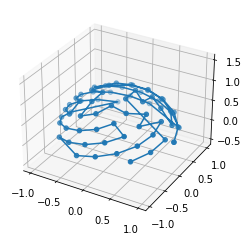

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = zip(*points)
ax.plot(x, y, z)
ax.scatter(x, y, z)
set_axes_equal(ax)

In [25]:
plt.close('all')